# Exercise 3
Ole Gunnar Hovland and Alexander Hatle

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [2]:
# Handed out code
def plot_solution(x, t, U, txt='Solution'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

In [3]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    # Modified to take vectors as input

    if len(v) + len(d) + len(w) > 3: 
        # v, d and w are vectors
        A = np.diag(v, -1) + np.diag(d) + np.diag(w, 1)
    else:
        e = np.ones(N)        # array [1,1,...,1] of length N
        A = v*np.diag(e[1:],-1) + d * np.diag(e) + w * np.diag(e[1:],1)
    return A

In [4]:
def crank(g, params, BC, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x, K)              # Initial values, endpoints included
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    if BC == 'EP':
        U[0, :] = K * np.exp(-c * t)
    elif BC == 'binary':
        U[0, :] = 0 * t
    
    # u(R,t) = u(R, 0)
    U[-1, :] = np.repeat(U[-1, 0], N+1)

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)
    

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        # Solving linear system
        U[1:-1, n+1] = np.linalg.solve(A, B.dot(U[1:-1, n]) + q - p )  # [1:-1] -> excluding endpoints
    return x, t, U

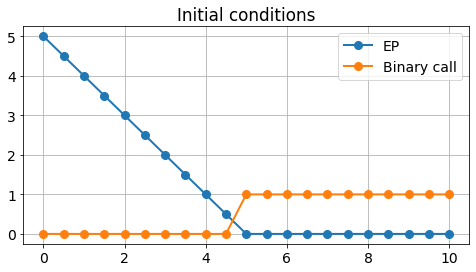

In [5]:
def european_put(x, K):
    sol = K-x
    sol[sol < 0] = 0
    return sol
def binary_call(x, K):
    sol = x-K
    sol[sol >= 0] = 1
    sol[sol < 0] = 0
    return sol

x = np.linspace(0, 10, 21)
K = 5
plt.title('Initial conditions')
plt.plot(x, european_put(x, K), '-o', label = 'EP')
plt.plot(x, binary_call(x, K), '-o', label = 'Binary call')
plt.legend()
plt.show()


h=2.0000, k=0.0200


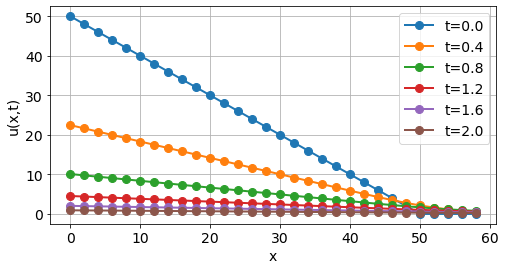

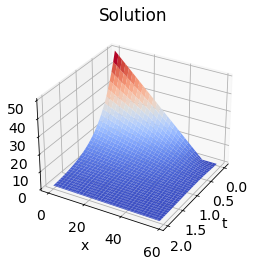

In [6]:
sigma = 0.2
r = 0.2
c = 2
K = 50
params = [sigma, r, c, K]

BC = 'EP'
if BC == 'binary':
    g = binary_call
elif BC == 'EP':
    g = european_put


x, t, U = crank(g = g, params = params, BC = BC, T = 2, R = 200, M = 100, N = 100)

plt.figure(1)
plt.clf()
tplots = np.linspace(0,t[-1],6)
k = t[1]-t[0]
for tn in tplots:
    n = int(tn/k)
    tn = n*k
    plt.plot(x[:30],U[:30,n],'-o',label='t={:.1f}'.format(tn))
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.show()

# Make a 3-d plot
plot_solution(x[:30], t, U[:30, :], txt='Solution')

## 1e)

In [7]:
def crank_modified(g, params, M=10, N=100, R = 1, T=0.5):
    # Input: 
    #       g: initial function for t=0
    #       params: a list containing parameters
    #               sigma, r, c and K
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    

    # Set the stepsizes
    h = R/M     # Stepsize in space
    k = T/N     # Stepsize in time

    # Parameters
    sigma = params[0]
    r = params[1]
    c = params[2]
    K = params[3]

    # Helping parameters
    alpha = sigma**2 * k / (4 * h**2)
    beta = r * k / (4*h)
    gamma = c * k / 2

    # Print the stepsizes, and r=k/h^2.
    print('h={:.4f}, k={:.4f}'.format(h,k))

    U = np.zeros((M+1,N+1))    # Array to store the solution, boundaries included.
    x = np.linspace(0,R,M+1)   # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)   # Gridpoints on the t-axis
    U[:,0] = g(x)              # Initial values, endpoints included

    # Boundary
    U[0, :] = 0
    U[-1, :] = R**2 * (1 + t)
    
    # Constructing C
    lowdiag = -alpha * x[2:-1]**2 - beta * x[2:-1]         # M-2
    diag =  2 * alpha * x[1:-1]**2 + gamma                 # M-1
    updiag = -alpha * x[1:-2]**2 + beta * x[1:-2]          # M-2
    C = tridiag(lowdiag, diag, updiag, M-1)

    # Constructing A and B
    A = np.eye(M-1) + C
    B = np.eye(M-1) - C

    # Boundary functions, bnddry0 = u(0, t), bndryR = u(R, t)
    

    # Constructing p and q
    p = np.zeros(M-1)
    q = np.zeros(M-1)
    # RHS
    def f(t):
        return (1+t) * x[1:-1]**2 * (1/(1 + t) - sigma**2 + 2*r + c)

    # Main loop 
    for n in range(N):
        # Updating p and q
        p[0] = (-alpha * x[1]**2 - beta * x[1]) * U[0,n+1]
        p[-1] = (-alpha * x[-2]**2 + beta * x[-2]) * U[-1,n+1]
        q[0] = (alpha * x[1]**2 + beta * x[1]) * U[0,n]
        q[-1] = (alpha * x[-2]**2 - beta * x[-2]) * U[-1,n]

        tempvec = B.dot(U[1:-1, n]) + q - p + k * f(t[n])
        U[1:-1, n+1] = np.linalg.solve(A, tempvec)  # [1:-1] -> excluding endpoints
        
    return x, t, U

In [8]:
def u_exact(x, t):
    return (1 + t) * x**2
def u0(x):
    return x**2

In [9]:
sigma = 0.1
r = 0.2
c = 0.5
K = 10
params = [sigma, r, c, K]
x, t, U = crank_modified(g = u0, params = params, T = 0.1, R = 80, M = 500, N = 500)

h=0.1600, k=0.0002


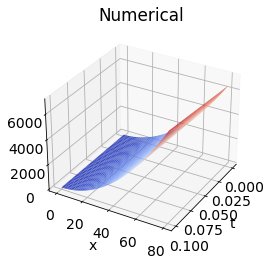

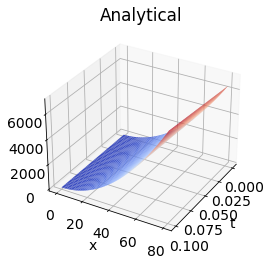

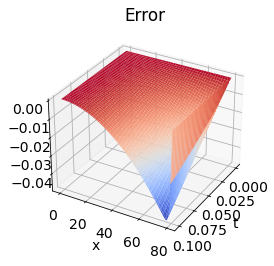

In [10]:
plot_solution(x, t, U, txt = 'Numerical')
tt, xx = np.meshgrid(t, x)
plot_solution(x, t, u_exact(xx, tt), txt = 'Analytical')
plot_solution(x, t, U - u_exact(xx, tt), txt = 'Error')

## Error as a function of h

In [11]:
def error_analysis(g, Ms, Ns, R, T, solver, params):
    i = 0
    error = np.zeros(max(Ms.size, Ns.size))
    for M in Ms:
        for N in Ns:
            x, t, U = solver(g = g, params = params, M = M, N = N, R = R, T = T)
            tt, xx = np.meshgrid(t, x)
            error[i]= np.max(np.abs(u_exact(x, t[-1]) - U[:,-1]))
            i += 1
    return error

h=1.2500, k=0.0010
h=0.6250, k=0.0010
h=0.3125, k=0.0010
h=0.1562, k=0.0010
h=0.0781, k=0.0010
h=0.0391, k=0.0010


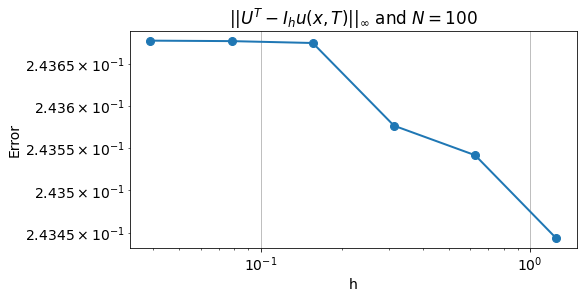

In [15]:
T = 0.1
R = 80
N = 100
Ns = np.array([N])
num = 6                   # Takes a long time ()
Ms = 2**(np.arange(6, num+6))     
hs = R / Ms


sigma = 0.1
r = 0.2
c = 0.5
K = 10
params = [sigma, r, c, K]

error_h = error_analysis(u0, Ms, Ns, R, T, crank_modified, params)

plt.figure(0)
plt.loglog(hs, error_h, '-o')
plt.xlabel('h')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$N={N}$')
plt.show()

Somehow we get that the error stays constant as a function of h (actually decreasing!). Obviously, this is wrong. Reason for the error decreasing is that when we take larger step sizes, we "skip" over the part with the largest error. 

Still, the error should not be constant as a function of h??

h=0.8000, k=0.0250
h=0.8000, k=0.0125
h=0.8000, k=0.0063
h=0.8000, k=0.0031
h=0.8000, k=0.0016
h=0.8000, k=0.0008
h=0.8000, k=0.0004
h=0.8000, k=0.0002
h=0.8000, k=0.0001
h=0.8000, k=0.0000
h=0.8000, k=0.0000
h=0.8000, k=0.0000


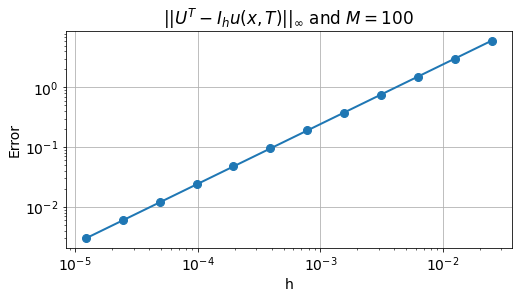

In [13]:
T = 0.1
R = 80
num = 12
Ns = 2**np.arange(2, num + 2)
ks = T/Ns
num = 8
M = 100
Ms = np.array([M])


error_k = error_analysis(u0, Ms, Ns, R, T, crank_modified, params)

plt.figure(0)
plt.loglog(ks, error_k, '-o')
plt.xlabel('h')
plt.ylabel('Error')
plt.title(r'$||U^T-I_hu(x,T)||_\infty$ and ' + rf'$M={M}$')
plt.show()

